# eBay Laptops & Netbooks - Modeling Price Prediction

In this project, we aim to build a predictive model for **estimating laptop prices** using a dataset which contains cleaned information from eBay's Laptops & Netbooks category, originally obtained via web scraping, which includes product attributes such as brand, specifications, and other listing details.

The model utilizes **CatBoost** (*Categorical Boosting*), a state-of-the-art gradient boosting library [developed by Yandex][Yandex CatBoost], renowned for its efficiency in handling categorical features and its strong performance in regression, classification & ranking.

<div align="center">
<img src="../assets/logos/catboost_logo.png" height="225" width="225"/>
</div>

[Yandex CatBoost]: https://yandex.com/dev/catboost/

## Importing Libraries

In this project, we will leverage several powerful libraries for efficient data manipulation, feature engineering, modeling, and hyperparameter tuning.

- **CatBoost**: The **core library** for modeling, used to design a gradient boosting model to handle categorical features effectively and provide good performance in regression tasks.
- **Scikit-learn**: Used for **training the model**, performing model evaluation, and splitting the dataset in train, validation & test sets.
- **Polars**: A high-performance DataFrame library optimized for speed and low memory usage.
- **Feature Engine**: A library for **feature engineering** that provides various techniques for transforming and selecting features, ensuring that our model has the most relevant data.
- **Optuna**: Utilized for **hyperparameter tuning**, automating the process of finding the best model parameters to improve performance.
- **SHAP**: Empowering **Explainable AI** via *model interpretability*, providing insights into how each feature influences the model's predictions, helping to explain the decisions made by the model.
- **Seaborn**: Used for **data visualization** & *Exploratory Data Analysis*. We will specifically leverage the `seaborn.objects` API, a more declarative and flexible approach to plotting, based on the *Grammar of Graphics*.
- **TextBlob**: A simple yet powerful library for **natural language processing (NLP)**, used here to analyze sentiments from some String variables.

These libraries will work together to ensure a streamlined and efficient manner for building and optimizing our predictive modeling.


In [7]:
# Importing libraries and setting constants

# Libraries
import os
from typing import Tuple

import catboost as cb
import matplotlib.pyplot as plt
import matplotlib.style as style
import optuna
import optuna.visualization as vis
import plotly
import polars as pl
import seaborn as sns
import seaborn.objects as so
import shap
from feature_engine.encoding import RareLabelEncoder
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from textblob import TextBlob

# Constants
RANDOM_SEED = 287  # Random seed for reproducibility
N_CORES_HALF = os.cpu_count() / 2  # Half the number of cores available
CSV_DATA_SOURCE_PATH = '../data/processed/ebay_laptops_and_netbooks_cleansed.csv'  # Path wherein the CSV cleansed data is located
PARQUET_DATA_SOURCE_PATH = '../data/processed/ebay_laptops_and_netbooks_cleansed.parquet'  # Path wherein the parquet cleansed data is located
READ_CSV_INSTEAD_OF_PARQUET = True # Whether to read the CSV cleansed data source or not


## Data Loading

We import the data set from the `DATA_SOURCE_PATH` location and check the first 5 rows.

In [8]:
df = pl.read_csv(CSV_DATA_SOURCE_PATH) if READ_CSV_INSTEAD_OF_PARQUET else pl.read_parquet(PARQUET_DATA_SOURCE_PATH)
df.head(n=5)

brand,currency,min_price,rating,five_star_scale_rating,ratings_count,condition_label,condition_description,seller_note,processor,screen_size_inches,manufacturer_color,color,hard_drive_size,hard_drive_size_unit,ram_size,ram_size_unit,ssd_size,ssd_size_unit,gpu_type,processor_speed,processor_speed_unit,laptop_type,release_year,display_width,display_height,model,os,features,country_of_manufacturer,storage_type
str,str,f64,str,f64,i64,str,str,str,str,f64,str,str,f64,str,f64,str,f64,str,str,f64,str,str,i64,i64,i64,str,str,str,str,str
"""unknown""","""$""",526.29,null,null,null,"""seller_refurbished""","""The item has been restored to …",null,null,null,"""other""","""other""",null,null,null,null,null,null,"""intel""",null,"""unknown""","""pc""",null,null,null,null,"""unknown""",null,"""unknown""","""unknown"""
"""unknown""","""$""",64.62,null,null,null,"""no_label""","""No description""",null,null,null,"""other""","""other""",null,null,null,null,null,null,"""unknown""",null,"""unknown""","""unknown""",null,null,null,null,"""unknown""",null,"""unknown""","""unknown"""
"""unknown""","""$""",682.88,null,null,null,"""seller_refurbished""","""The item has been restored to …",null,null,null,"""other""","""gray""",null,null,null,null,null,null,"""intel""",null,"""unknown""","""unknown""",null,null,null,null,"""unknown""",null,"""unknown""","""unknown"""
"""unknown""","""$""",317.73,null,null,null,"""new""","""A brand-new, unused, unopened,…",null,null,null,"""other""","""other""",null,null,null,null,null,null,"""unknown""",null,"""unknown""","""unknown""",null,null,null,null,"""unknown""",null,"""unknown""","""unknown"""
"""auo""","""$""",91.7,null,null,null,"""new""","""A brand-new, unused, unopened,…",null,"""does_not_apply""",null,"""other""","""other""",null,null,null,null,null,null,"""unknown""",null,"""unknown""","""unknown""",null,null,null,null,"""unknown""",null,"""unknown""","""unknown"""


As the data is already cleansed, there is little need for further operations. However, one might want to examine the dataset, visualize patterns in th e data and maybe create new features from existing variables, which we'll do in sections: **Exploratory Data Analysis** & **Feature Engineering**.

For further details on how the data cleansing process was carried out, feel free to check the *Data Cleansing Notebook* in either [GitHub][CLEANSING_NOTEBOOK_GITHUB_URL] or [Kaggle][CLEANSING_NOTEBOOK_KAGGLE_URL].


[CLEANSING_NOTEBOOK_GITHUB_URL]: https://github.com/jxareas/laptop-price-catboost/blob/master/notebooks/laptop_data_cleansing.ipynb
[CLEANSING_NOTEBOOK_KAGGLE_URL]: .

## Exploratory Data Analysis - EDA

Exploratory Data Analysis (**EDA**) is the process of **examining, summarizing, and visualizing a dataset** to uncover patterns, detect anomalies, and gain insights before applying statistical analysis methods. The goal of EDA is to **understand the structure and distribution of the data**, ensuring that it is clean, relevant, and well-prepared for modeling.

### Why is EDA important?
Before training a predictive model, it’s crucial to analyze the dataset to:
- **Summary Statistics**: Mean, median, standard deviation, and percentiles to understand central tendency and spread.
- **Visualizations**: Histograms, box plots, and scatter plots to spot skewness, outliers, and trends.
- **Correlation Analysis**: Examining relationships between variables to detect collinearity or important dependencies.



### Exploring the Data Set

#### Data Types

In [9]:
df_column_dtypes = pl.DataFrame(data={
    'column': df.columns,
    'dtype': [str(dtype).split('(', 1)[0] for dtype in df.dtypes]  # Remove everything after '('
})
df_column_dtypes

column,dtype
str,str
"""brand""","""String"""
"""currency""","""String"""
"""min_price""","""Float64"""
"""rating""","""String"""
"""five_star_scale_rating""","""Float64"""
…,…
"""model""","""String"""
"""os""","""String"""
"""features""","""String"""


In [10]:
(
    df_column_dtypes
    .group_by(by='dtype')
    .agg(pl.count('column'))
    .sort(by='column', descending=True)
)

by,column
str,u32
"""String""",20
"""Float64""",7
"""Int64""",4


#### Summary Statistics

Before anything else, we check some of the summary statistics for each variable, that is, their count, average, standard deviation, etc.

In [11]:
df.describe()

statistic,brand,currency,min_price,rating,five_star_scale_rating,ratings_count,condition_label,condition_description,seller_note,processor,screen_size_inches,manufacturer_color,color,hard_drive_size,hard_drive_size_unit,ram_size,ram_size_unit,ssd_size,ssd_size_unit,gpu_type,processor_speed,processor_speed_unit,laptop_type,release_year,display_width,display_height,model,os,features,country_of_manufacturer,storage_type
str,str,str,f64,str,f64,f64,str,str,str,str,f64,str,str,f64,str,f64,str,f64,str,str,f64,str,str,f64,f64,f64,str,str,str,str,str
"""count""","""4475""","""4475""",4475.0,"""220""",220.0,220.0,"""4475""","""4475""","""1119""","""3005""",2653.0,"""4475""","""4475""",1115.0,"""1883""",1659.0,"""1661""",2203.0,"""2229""","""4475""",2139.0,"""4475""","""4475""",608.0,1757.0,1757.0,"""2516""","""4475""","""2040""","""4475""","""4475"""
"""null_count""","""0""","""0""",0.0,"""4255""",4255.0,4255.0,"""0""","""0""","""3356""","""1470""",1822.0,"""0""","""0""",3360.0,"""2592""",2816.0,"""2814""",2272.0,"""2246""","""0""",2336.0,"""0""","""0""",3867.0,2718.0,2718.0,"""1959""","""0""","""2435""","""0""","""0"""
"""mean""",null,null,330.473499,null,4.579545,36.613636,null,null,null,null,13.802544,null,null,228.67548,null,20.451477,null,268.47922,null,null,2.674403,null,null,2019.333882,1668.900398,962.07399,null,null,null,null,null
"""std""",null,null,393.470717,null,0.580733,178.959476,null,null,null,null,1.613322,null,null,223.964855,null,204.630743,null,225.465882,null,null,17.267134,null,null,3.113245,481.707245,307.982614,null,null,null,null,null
"""min""","""acer""","""$""",4.42,"""1_out_of_5_stars""",1.0,1.0,"""certified_refurbished""","""A brand-new, unused, unopened,…","""“""Excellent Condition Touch Sc…","""10th_gen_intel_core_i5""",2.0,"""black""","""beige""",0.0,"""gigabytes""",1.0,"""gigabytes""",0.0,"""gigabytes""","""amd""",1.0,"""GHz""","""laptop""",2000.0,800.0,480.0,"""100e_chromebook""","""android""",""".""","""australia""","""emmc"""
"""25%""",null,null,99.99,null,4.5,2.0,null,null,null,null,13.0,null,null,16.0,null,4.0,null,120.0,null,null,1.8,null,null,2018.0,1280.0,720.0,null,null,null,null,null
"""50%""",null,null,235.0,null,4.5,4.0,null,null,null,null,14.0,null,null,256.0,null,8.0,null,240.0,null,null,2.3,null,null,2020.0,1366.0,768.0,null,null,null,null,null
"""75%""",null,null,411.49,null,5.0,16.0,null,null,null,null,15.0,null,null,500.0,null,16.0,null,480.0,null,null,2.6,null,null,2022.0,1920.0,1080.0,null,null,null,null,null
"""max""","""zzetze""","""$""",3901.0,"""5_out_of_5_stars""",5.0,1533.0,"""very_good_refurbished""","""The item shows moderate wear a…","""“✅ Refurbished ✅ inkl. 19% MwS…","""v19""",18.4,"""teal""","""yellow""",3500.16,"""unknown""",8192.0,"""unknown""",1024.0,"""unknown""","""unknown""",800.0,"""unknown""","""unknown""",2024.0,3840.0,2400.0,"""zbook_14u_g6""","""windows""","""wifi,webcam,bt""","""unknown""","""unknown"""


#### Null Count

We also take a look at the null count for each column, which --as evidenced below-- varies heavily, from the target variable `min_price` having no nulls whatsoever, to the `rating` columns having an extremely high percentage (95%!) of null values.

In [12]:
df.null_count().unpivot(
    variable_name='variable',
    value_name='null_count'
).with_columns(
    (pl.col('null_count') / df.height).round(2).alias('proportion')
).sort(
    by='null_count',
    descending=True,
)

variable,null_count,proportion
str,u32,f64
"""rating""",4255,0.95
"""five_star_scale_rating""",4255,0.95
"""ratings_count""",4255,0.95
"""release_year""",3867,0.86
"""hard_drive_size""",3360,0.75
…,…,…
"""processor_speed_unit""",0,0.0
"""laptop_type""",0,0.0
"""os""",0,0.0


### Analyzing the target variable - `min_price`

In this dataset, **`min_price`** represents the **minimum price listed** in U$ dollars for laptops and netbooks on eBay. This is our **target variable** for the regression problem we are analyzing, meaning our goal is to predict the minimum price based on other product attributes such as the laptop's brand, specifications, and software/hardware features.

We start by using the `describe()` method to get a summary of the `min_price` feature, which provides us with an overview of the distribution of minimum prices across the dataset.

In [13]:
df['min_price'].describe()

statistic,value
str,f64
"""count""",4475.0
"""null_count""",0.0
"""mean""",330.473499
"""std""",393.470717
"""min""",4.42
"""25%""",99.99
"""50%""",235.0
"""75%""",411.49
"""max""",3901.0


- **Count**: The dataset has $4,475$ rows, with **no missing values** (as indicated by `null_count = 0`), meaning the data is complete.
- **Mean**: The average minimum price of the laptops is around $330$ U$D, which gives us a general idea of the typical price point.
- **Standard Deviation**: The large standard deviation relative to the mean suggests that the data has a **wide spread** with significant variance, likely driven by a few high-priced outliers.


Following the summary statistics for `min_price`, we plot its distribution using a combination of a **histogram** and a **Kernel Density Estimate (KDE)** plot. The **histogram** shows the frequency of price ranges, while the **KDE** provides a smoothed curve to better understand the overall shape of the distribution.

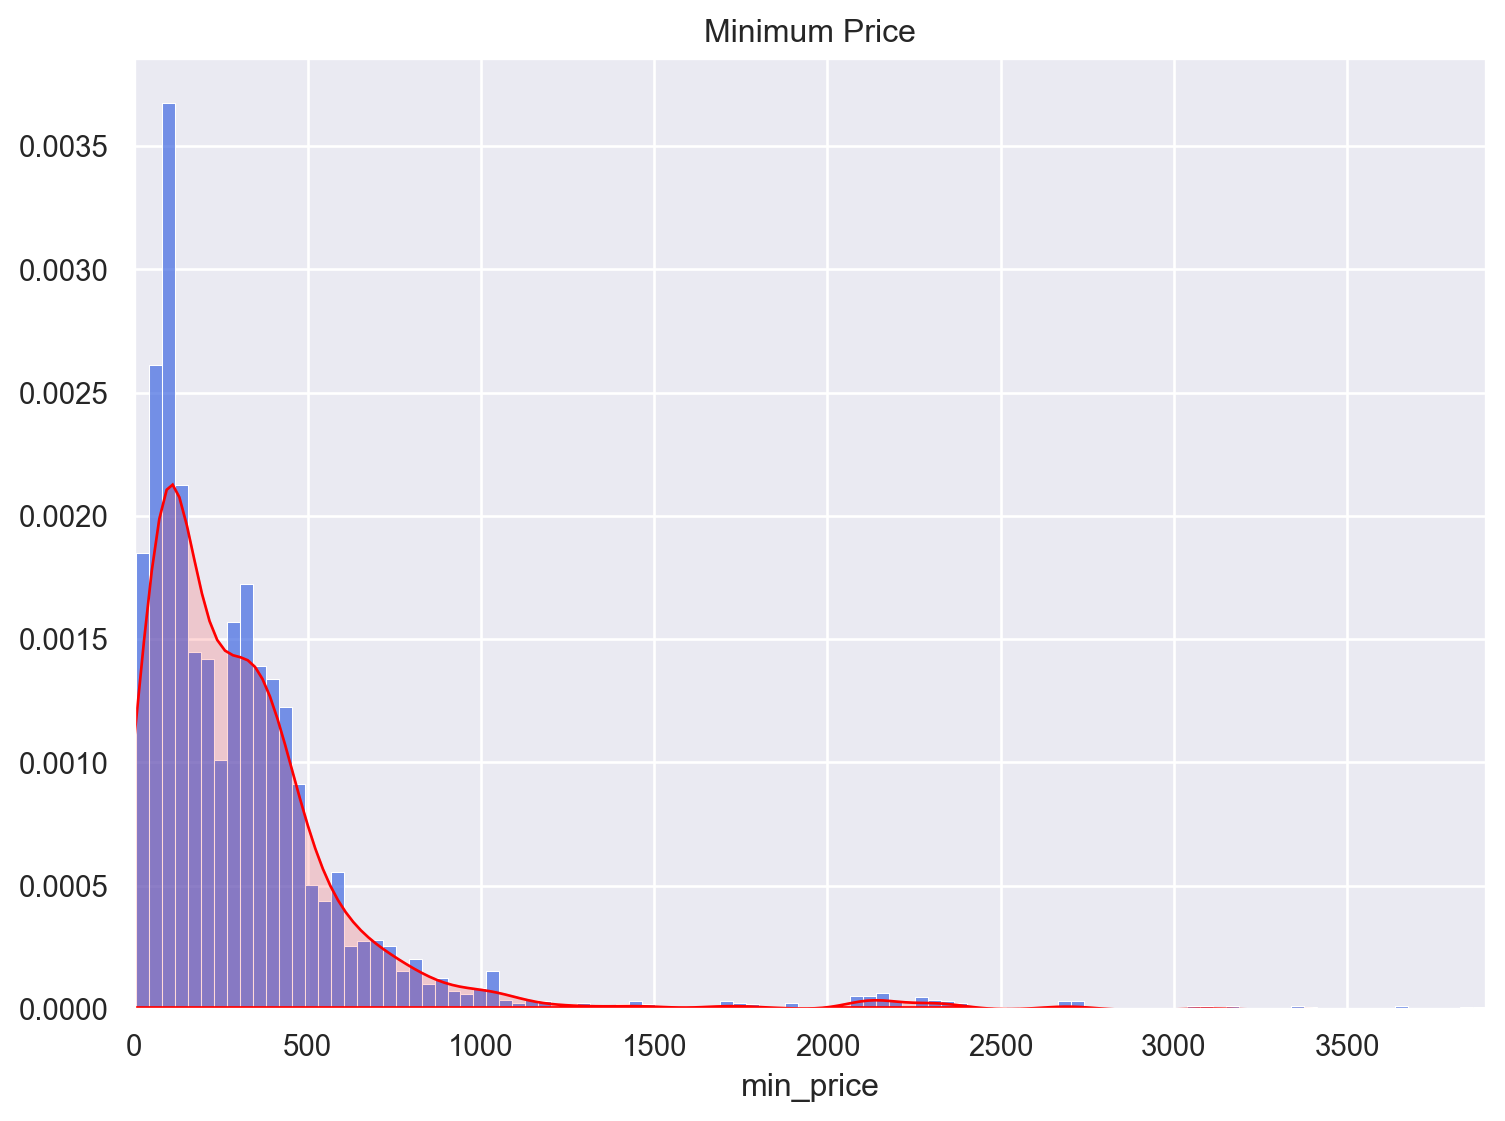

In [14]:
(
    so.Plot(df, x='min_price')
    .add(so.Bars(color='royalblue'), so.Hist('density'))
    .add(so.Area(color='red', alpha=.15), so.KDE())
    .limit(x=(0, df['min_price'].max()))
    .label(title='Minimum Price', x='min_price')
    .layout(size=(8, 6))
)

From the plot, we can clearly visualize that most listings are priced in a compact and relatively low range ($0-500$ USD), while there are some listings with much higher prices ($1500+$ USD), which could represent high-end laptops.

In other words, this figure reveals that the `min_price` data distribution **is heavily skewed to the right**, with most of the listings concentrated around lower price points but a small number of listings pushing the prices significantly higher.

This kind of skew is common in pricing, where most products are affordable, but a few high-end or premium items raise the overall price range.

In [15]:
## TODO : More EDA - AutoEDA? (SweetViz, AutoViz, pandas-profiling) or manual? TBD

## Feature Engineering


### Feature Creation

#### **Sentiment Analysis** for `seller_note`

In this section, we perform sentiment analysis on the `seller_note` feature from the eBay dataset using [TextBlob][TextBlob], a simple library that helps analyze and process textual data, built upon Python's [Natural Language Toolkit][NLTK]. The goal is to evaluate the sentiment expressed in the seller's notes, identifying whether the comments are **positive**, **negative**, or **neutral**.

We calculate the *polarity* and *subjectivity* of each note to understand the sentiment's intensity and whether it reflects personal opinions or objective facts. This simple analysis can help **assess the overall tone of the seller's descriptions**.

Notes:
- **Polarity** measures the sentiment's intensity, ranging from **-1** (negative) to **+1** (positive).
  A score close to **0** indicates neutral sentiment.
- **Subjectivity** measures how subjective or opinionated the text is, ranging from **0** (very objective) to **1** (very subjective). Higher subjectivity indicates that the text reflects personal opinions or feelings, while lower subjectivity suggests it is more factual.

<div align="center">
<img src="../assets/images/textblob_working.png" height="100" width="550"/>
<br>
<a href="https://www.researchgate.net/figure/Working-of-the-TextBlob-method_fig7_350191934"><i>Working of the TextBlob method</i></a>
</div>

[TextBlob]: https://github.com/sloria/TextBlob
[NLTK]: https://github.com/nltk/nltk

We start by taking a look at some of the seller notes which appear in the dataset.

In [16]:
df.select(
    'seller_note'
).filter(
    pl.col('seller_note').is_not_null()
).head(n=10).to_pandas()

,seller_note
0,“GRADO------- B ---------prima di acquistare l...
1,“AAA PCs is a Microsoft Authorized Refurbisher...
2,“FOR PARTS ONLY - DOES NOT WORK EVEN THOUGH IT...
3,"“This item is in excellent condition, I would ..."
4,“Laptops is tested & fully working with some s...
5,“FACTORY SEALED IN ORIGINAL HP MFR. REFURBISHE...
6,"“This laptop has been ""CERTIFIED FACTORY REFUR..."
7,“This item has been harvested from a working e...
8,"“Certified, Excellent. Includes all genuine ne..."
9,“Light scuffs to the housing and body from nor...


We continue by creating functions which will allow us to extract the sentiment, polarity and subjectivity from each of the notes.

In [17]:
def get_sentiment_label_by_polarity(polarity: float, threshold: float = 0.1) -> str:
    """
    Assigns a sentiment label based on polarity.

    Parameters:
    -----------
    polarity : float
        The polarity score (-1 to 1).

    threshold : float, optional, default=0.1
        The threshold for determining the label: 'positive', 'negative', or 'neutral'.

    Returns:
    --------
    str
        A sentiment label ('positive', 'negative', or 'neutral').
    """
    if polarity > threshold:
        return "positive"
    elif polarity < -threshold:
        return "negative"
    return "neutral"


def get_sentiment_features(text: str, threshold: float = 0.1) -> Tuple[float, float, str]:
    """
    Analyzes sentiment of the given text using TextBlob.

    Parameters:
    -----------
    text : str
        The text to analyze (e.g., seller note).

    threshold : float, optional, default=0.1
        The threshold for determining sentiment labels.

    Returns:
    --------
    Tuple[float, float, str]
        - polarity (float): The polarity score (-1 to 1).
        - subjectivity (float): The subjectivity score (0 to 1).
        - sentiment_label (str): 'positive', 'negative', or 'neutral'.
    """
    blob = TextBlob(text)

    polarity = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity
    sentiment_label = get_sentiment_label_by_polarity(polarity, threshold)

    return polarity, subjectivity, sentiment_label


In [18]:
def get_polarity(text: str, threshold: float = 0.1) -> float:
    """
    Extracts the polarity score from the sentiment of the given text.

    Parameters:
    -----------
    text : str
        The text to analyze for sentiment polarity.

    threshold : float, optional, default=0.1
        The threshold for determining sentiment polarity, passed to
        the `get_sentiment_features` function.

    Returns:
    --------
    float
        The polarity score, ranging from -1 (negative) to 1 (positive).
    """
    polarity, _, _ = get_sentiment_features(text, threshold)
    return polarity


def get_subjectivity(text: str, threshold: float = 0.1) -> float:
    """
    Extracts the subjectivity score from the sentiment of the given text.

    Parameters:
    -----------
    text : str
        The text to analyze for sentiment subjectivity.

    threshold : float, optional, default=0.1
        The threshold for determining sentiment polarity, passed to
        the `get_sentiment_features` function.

    Returns:
    --------
    float
        The subjectivity score, ranging from 0 (objective) to 1 (subjective).
    """
    _, subjectivity, _ = get_sentiment_features(text, threshold)
    return subjectivity


def get_sentiment_label(text: str, threshold: float = 0.1) -> str:
    """
    Extracts the sentiment label ('positive', 'negative', or 'neutral')
    based on the polarity of the given text.

    Parameters:
    -----------
    text : str
        The text to analyze for sentiment and label.

    threshold : float, optional, default=0.1
        The threshold for determining sentiment polarity, passed to
        the `get_sentiment_features` function.

    Returns:
    --------
    str
        The sentiment label: 'positive', 'negative', or 'neutral'.
    """
    _, _, sentiment_label = get_sentiment_features(text, threshold)
    return sentiment_label


Now we can extract the polarity, subjectivity and the sentiment from each of the seller notes!

In [19]:
df = df.with_columns(
    # Polarity
    pl.col('seller_note')
    .map_elements(function=get_polarity, return_dtype=pl.Float64)
    .alias('seller_note_polarity'),
    # Subjectivity
    pl.col('seller_note')
    .map_elements(function=get_subjectivity, return_dtype=pl.Float64)
    .alias('seller_note_subjectivity'),
    # Sentiment Label
    pl.col('seller_note')
    .map_elements(function=get_sentiment_label, return_dtype=pl.Utf8)
    .alias('seller_note_sentiment_label'),
)

After creating the columns with `polars`, we visualize the newly created features:

In [20]:
df.select(
    'seller_note', 'seller_note_polarity', 'seller_note_subjectivity', 'seller_note_sentiment_label'
).filter(
    pl.col('seller_note').is_not_null()
).with_columns(
    pl.col('seller_note_polarity').round(2).alias('seller_note_polarity'),
    pl.col('seller_note_subjectivity').round(2).alias('seller_note_subjectivity'),
)

seller_note,seller_note_polarity,seller_note_subjectivity,seller_note_sentiment_label
str,f64,f64,str
"""“GRADO------- B ---------prima…",0.0,0.0,"""neutral"""
"""“AAA PCs is a Microsoft Author…",0.28,0.54,"""positive"""
"""“FOR PARTS ONLY - DOES NOT WOR…",0.05,0.65,"""neutral"""
"""“This item is in excellent con…",0.62,0.79,"""positive"""
"""“Laptops is tested & fully wor…",0.0,0.0,"""neutral"""
…,…,…,…
"""““Item is Seller Refurbished, …",0.01,0.37,"""neutral"""
"""“Used in good working conditio…",0.7,0.6,"""positive"""
"""“Completely refur with new O/S…",0.12,0.43,"""positive"""


#### **Visualization** - Seller Note Polarity

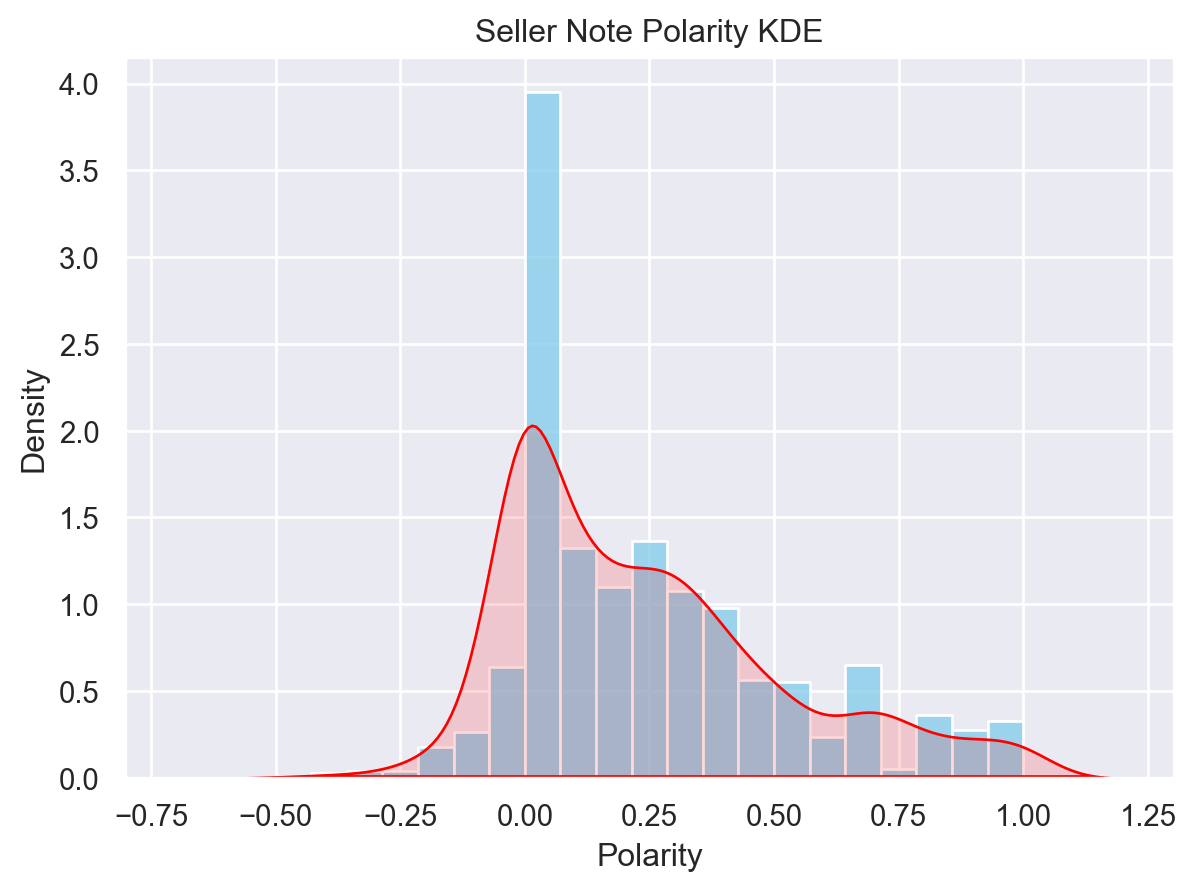

In [21]:
(
    so.Plot(df, x='seller_note_polarity')
    .add(so.Bars(color='skyblue', alpha=.8), so.Hist('density'))
    .add(so.Area(color='red', alpha=.15), so.KDE())
    .label(title='Seller Note Polarity KDE', x='Polarity', y='Density')
)

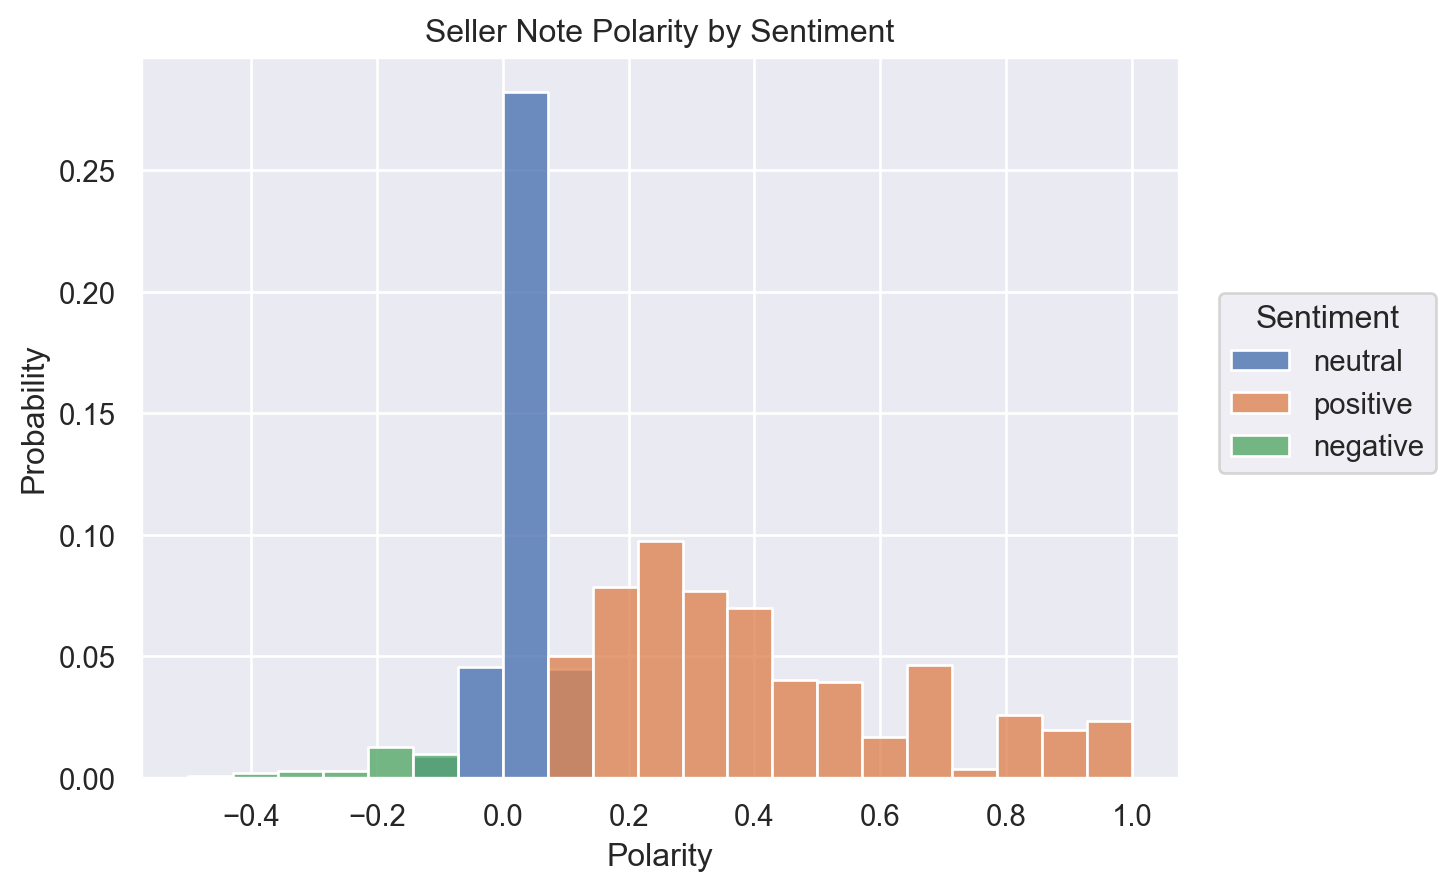

In [22]:
(
    so.Plot(df, x='seller_note_polarity', color='seller_note_sentiment_label')
    .add(so.Bars(alpha=.8), so.Hist('probability'))
    .label(title='Seller Note Polarity by Sentiment', x='Polarity', y='Probability', color='Sentiment')
)

#### **Visualization** - Seller Note Subjectivity

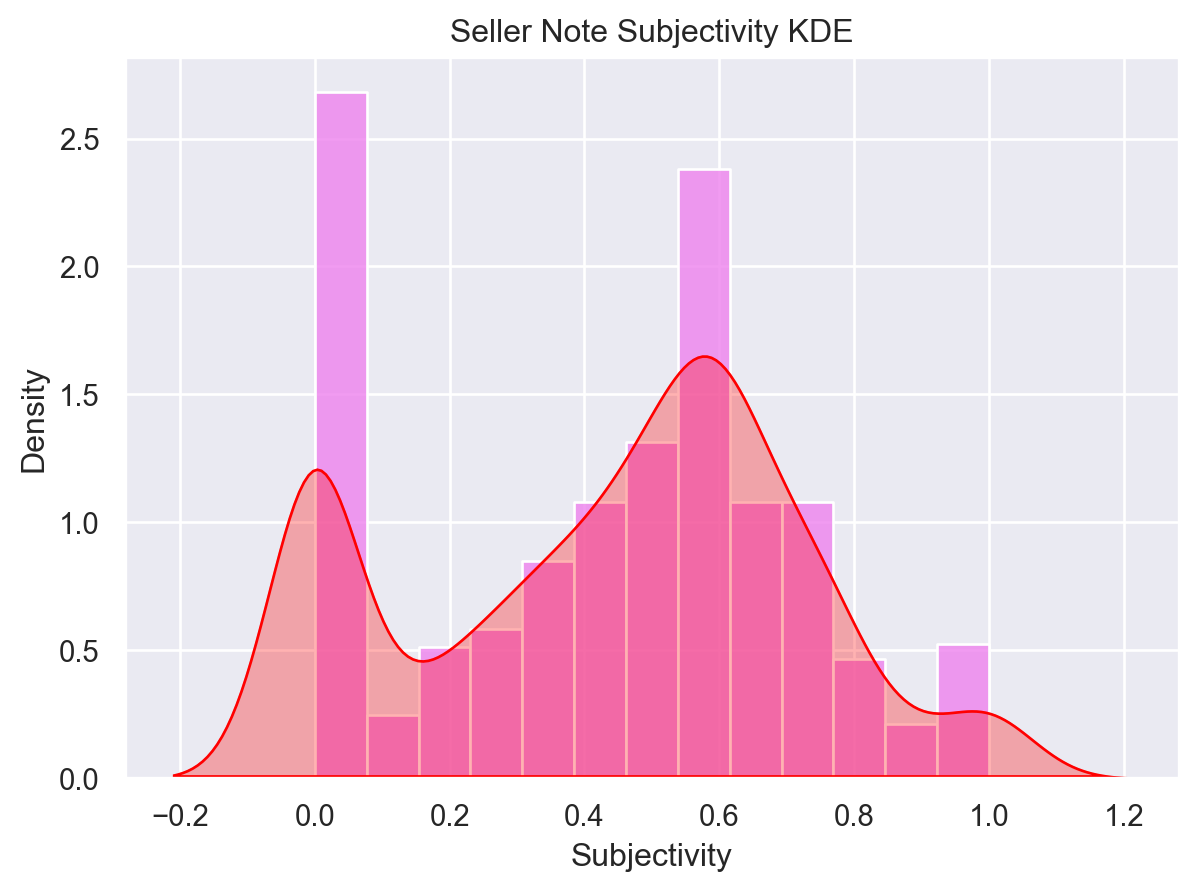

In [23]:
(
    so.Plot(df, x='seller_note_subjectivity')
    .add(so.Bars(color='violet', alpha=.8), so.Hist('density'))
    .add(so.Area(color='red', alpha=.3), so.KDE())
    .label(title='Seller Note Subjectivity KDE', x='Subjectivity', y='Density')
)

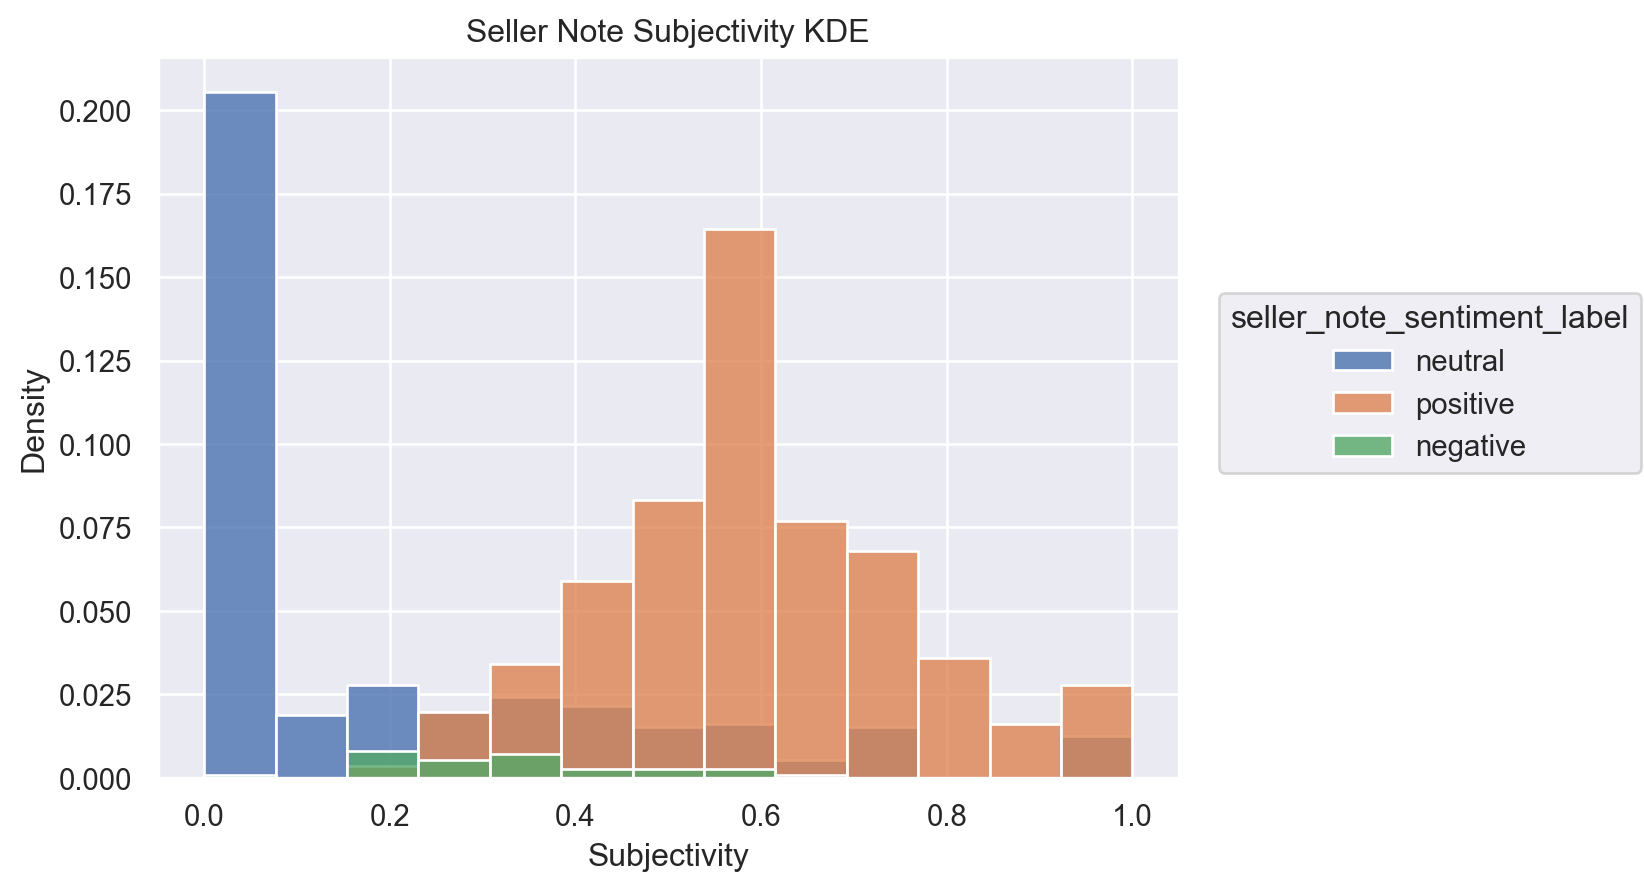

In [24]:
(
    so.Plot(df, x='seller_note_subjectivity', color='seller_note_sentiment_label')
    .add(so.Bars(alpha=.8), so.Hist('probability'))
    .label(title='Seller Note Subjectivity KDE', x='Subjectivity', y='Density')
)

#### **Visualization** - Seller Note Sentiment

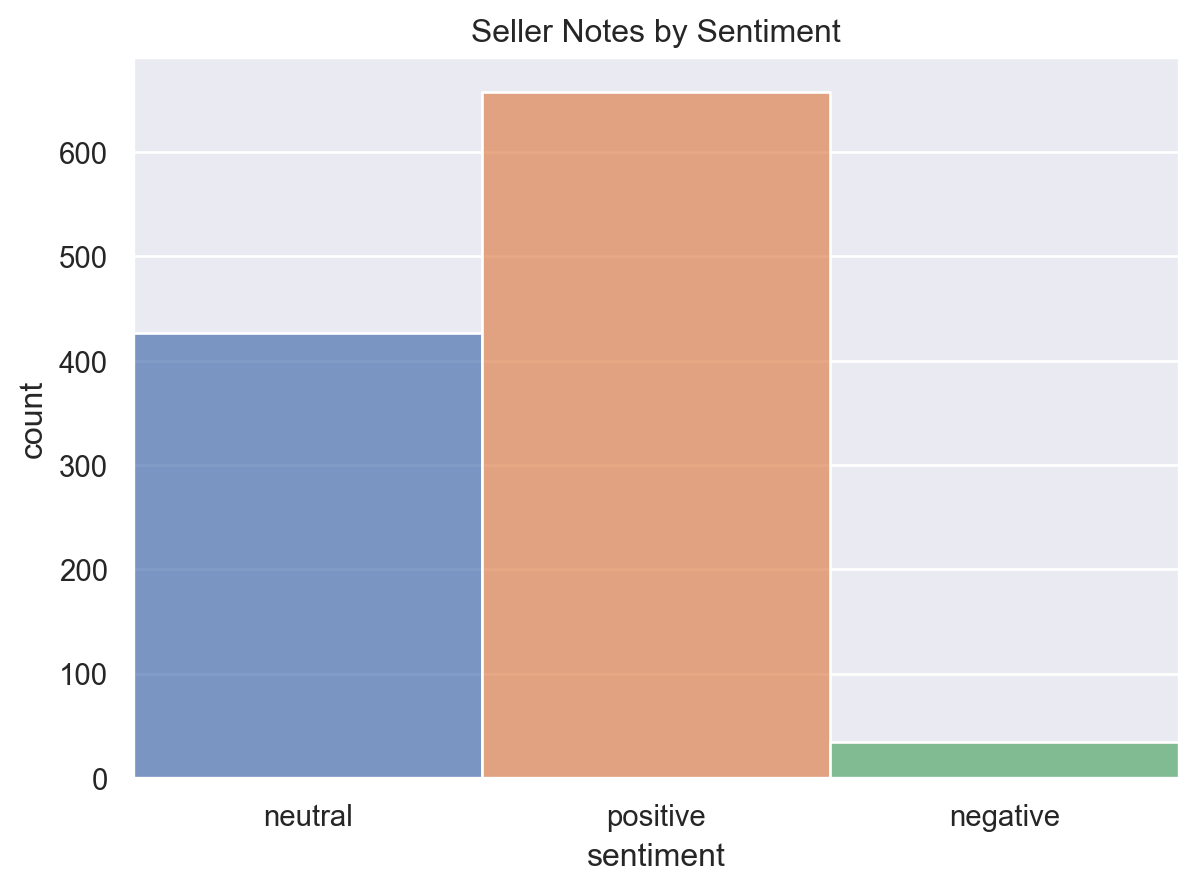

In [25]:
(
    so.Plot(df, x='seller_note_sentiment_label', color='seller_note_sentiment_label')
    .add(so.Bars(), so.Hist(), legend=False)
    .label(title='Seller Notes by Sentiment', x='sentiment', y='count')
)

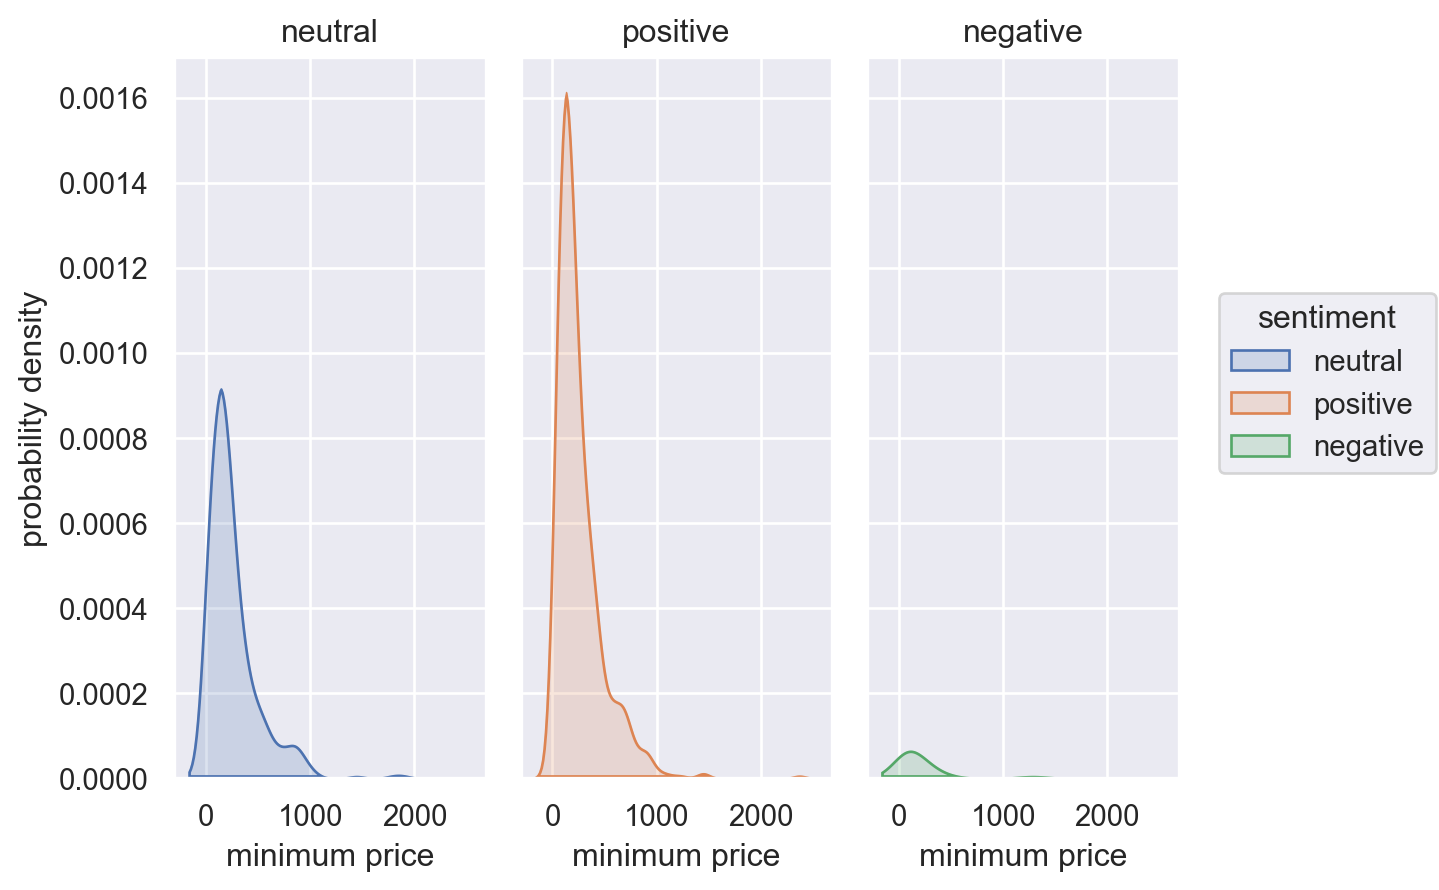

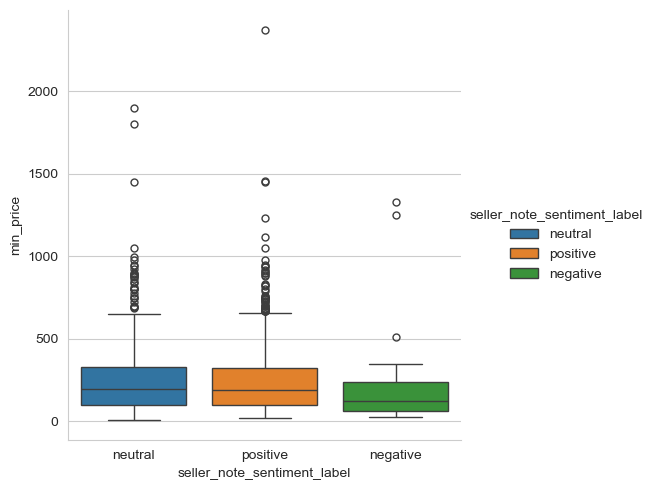

In [26]:
sns.catplot(data=df, x='seller_note_sentiment_label', kind='box', y='min_price', hue='seller_note_sentiment_label')

(
    so.Plot(df, x="min_price", color='seller_note_sentiment_label')
    .facet("seller_note_sentiment_label")
    .add(so.Area(), so.KDE())
    .label(x='minimum price', y='probability density', color='sentiment')
)

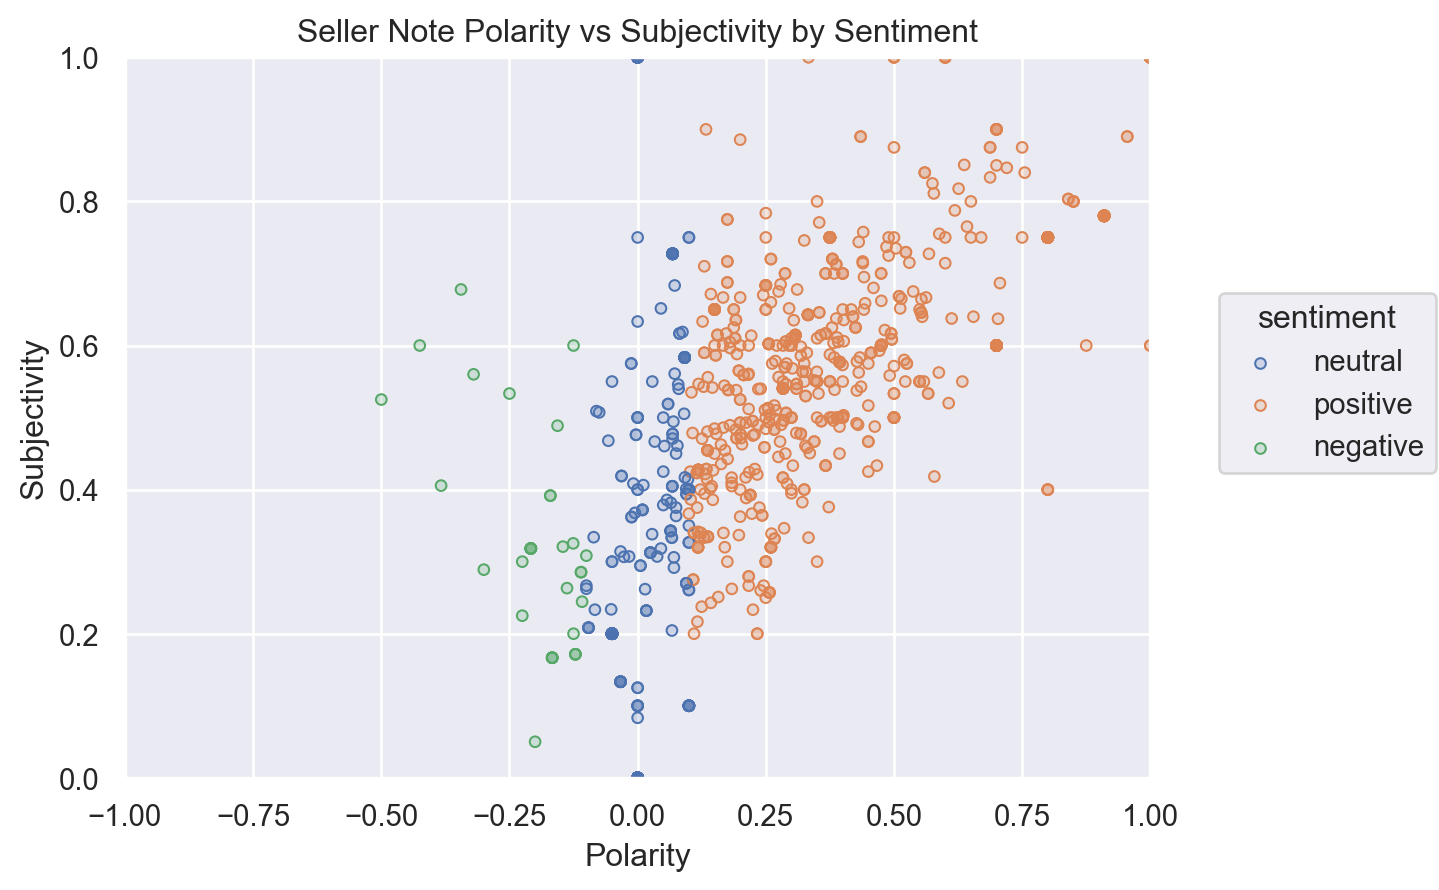

In [27]:
(
    so.Plot(df, x='seller_note_polarity', y='seller_note_subjectivity', color='seller_note_sentiment_label')
    .add(so.Dots())
    .limit(x=(-1, 1), y=(0, 1))
    .label(title='Seller Note Polarity vs Subjectivity by Sentiment', x='Polarity', y='Subjectivity', color='sentiment')
)

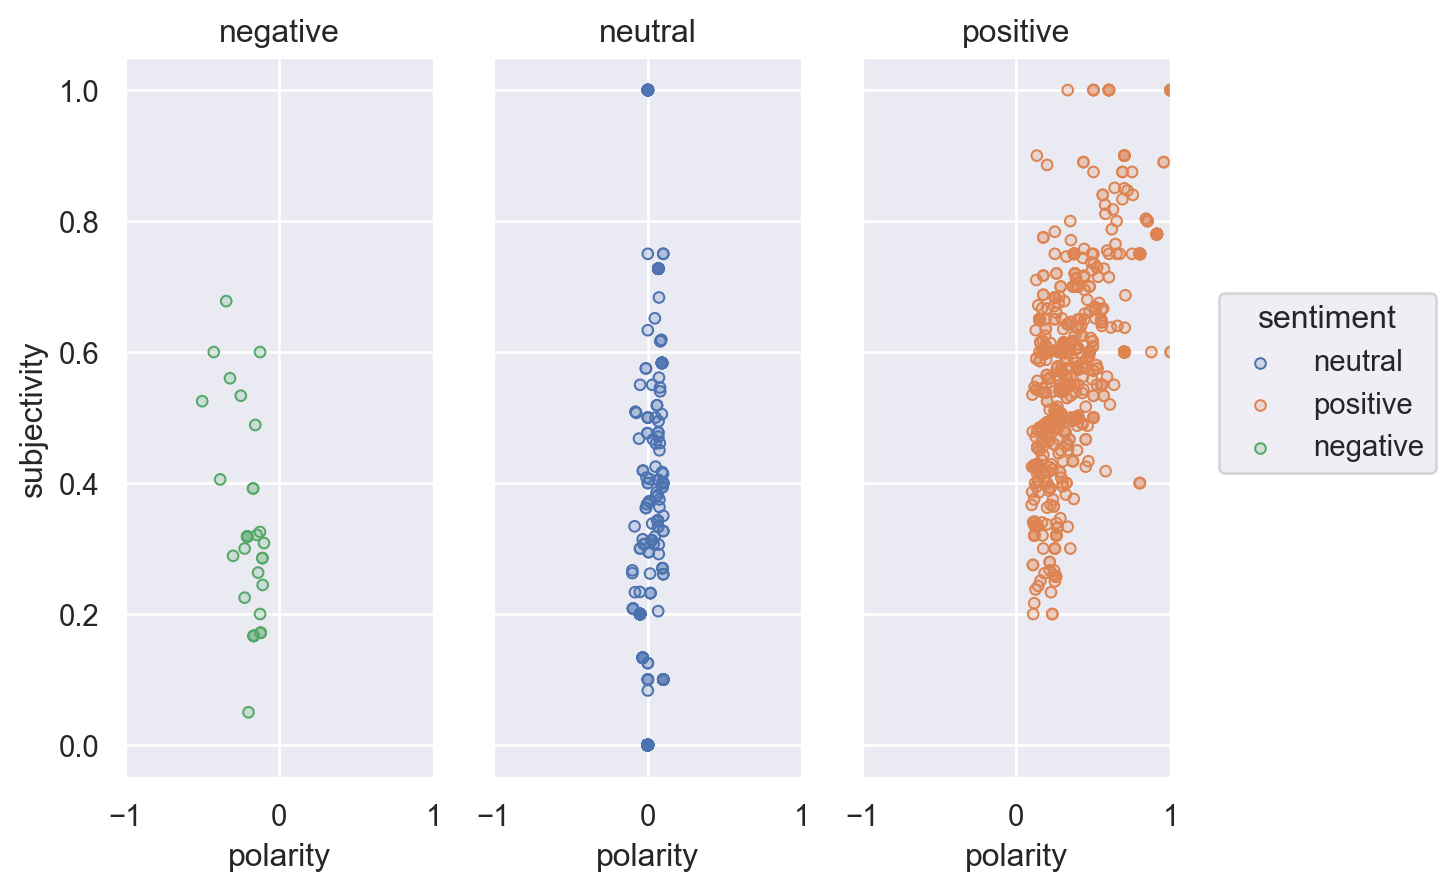

In [28]:
(
    so.Plot(df, x="seller_note_polarity", y='seller_note_subjectivity', color='seller_note_sentiment_label')
    .facet("seller_note_sentiment_label", order=['negative', 'neutral', 'positive'])
    .add(so.Dots())
    .limit(x=(-1, 1))
    .label(x='polarity', y='subjectivity', color='sentiment')
)

#### Standardizing hard drive, RAM & SSD size to their size in gigabytes

In [29]:
df.select([
    pl.col(col).unique().alias(col)
    for col in df.columns if col.endswith('_unit') and not col.startswith('processor')
])

hard_drive_size_unit,ram_size_unit,ssd_size_unit
str,str,str
"""terabytes""","""megabytes""","""terabytes"""
"""unknown""",null,"""gigabytes"""
"""gigabytes""","""unknown""","""unknown"""
null,"""gigabytes""",null


In [30]:
def convert_to_gb(df_to_convert: pl.DataFrame, size_column: str, unit_column: str):
    """
    Convert size values to gigabytes based on the unit column.

    Args:
        df_to_convert (pl.DataFrame): DataFrame with size and unit columns.
        size_column (str): Column containing size values.
        unit_column (str): Column containing units (e.g., 'gigabytes', 'megabytes', 'terabytes').

    Returns:
        pl.DataFrame: DataFrame with a new column `<size_column>_in_gb` containing size in gigabytes.
    """
    return df_to_convert.with_columns(
        pl.when(df_to_convert[unit_column] == "gigabytes").then(df_to_convert[size_column])
        .when(df_to_convert[unit_column] == "megabytes").then(df_to_convert[size_column] / 1024)
        .when(df_to_convert[unit_column] == "terabytes").then(df_to_convert[size_column] * 1024)
        .otherwise(None).alias(f"{size_column}_in_gb")
    )


In [31]:
size_columns = [col for col in df.columns if col.endswith('_size')]

for size_col in size_columns:
    unit_col = f"{size_col}_unit"
    df = convert_to_gb(df, size_col, unit_col)

In [32]:
for size in size_columns:
    print(f'Non-null values for {size}: {df[size].drop_nulls().len()}')
    size_in_gb = f'{size}_in_gb'
    print(f'Non-null values for {size_in_gb}: {df[size_in_gb].drop_nulls().len()}\n')

Non-null values for hard_drive_size: 1115
Non-null values for hard_drive_size_in_gb: 1105

Non-null values for ram_size: 1659
Non-null values for ram_size_in_gb: 1656

Non-null values for ssd_size: 2203
Non-null values for ssd_size_in_gb: 2187



### Feature Selection

In [33]:
# The target variable : the minimum price required to purchase an item (laptop/netbook)
target_var = 'min_price'
# A polars expression for feature selection
feature_selection_expr = pl.all().exclude(target_var, 'currency', 'condition_description', 'seller_note',
                                          'hard_drive_size', 'ram_size', 'ssd_size', )

# Dataframe holding all feature variables
df_features = df.select(
    feature_selection_expr
)
# Series holding the target vector
series_target = df[target_var]

### Categorical Features

In [34]:
feature_names = df_features.columns
cat_feature_names = df_features.select(
    pl.col(pl.String),
).columns

print(f'All Features: \n{feature_names}')
print(f'Categorical Features: \n{cat_feature_names}')

All Features: 
['brand', 'rating', 'five_star_scale_rating', 'ratings_count', 'condition_label', 'processor', 'screen_size_inches', 'manufacturer_color', 'color', 'hard_drive_size_unit', 'ram_size_unit', 'ssd_size_unit', 'gpu_type', 'processor_speed', 'processor_speed_unit', 'laptop_type', 'release_year', 'display_width', 'display_height', 'model', 'os', 'features', 'country_of_manufacturer', 'storage_type', 'seller_note_polarity', 'seller_note_subjectivity', 'seller_note_sentiment_label', 'hard_drive_size_in_gb', 'ram_size_in_gb', 'ssd_size_in_gb']
Categorical Features: 
['brand', 'rating', 'condition_label', 'processor', 'manufacturer_color', 'color', 'hard_drive_size_unit', 'ram_size_unit', 'ssd_size_unit', 'gpu_type', 'processor_speed_unit', 'laptop_type', 'model', 'os', 'features', 'country_of_manufacturer', 'storage_type', 'seller_note_sentiment_label']


### Encoding rare labels

Rare categories in a dataset can introduce **high cardinality**, making statistical analysis and model generalization more challenging. By setting a **minimum frequency threshold**, we ensure that only sufficiently common categories remain distinct, while rare ones are grouped into an "other" category.

In this project, we'll leverage the [**Feature-engine**][Feature-Engine] package to handle categorical variables efficiently, specifically using `RareLabelEncoder` to group infrequent categories under a common label.

This reduces noise, prevents overfitting, and enhances model interpretability without significantly losing information.

<div align="center">
<img src="../assets/logos/feature_engine.png" height="150" width="150"/>
<img src="../assets/images/rare_label_encoding.png" height="300" width="500"/>
</div>

[Feature-Engine]: https://github.com/feature-engine/feature_engine

In [35]:
# Sets the minimum count for a category to be kept separately, categories with fewer than 20 occurrences will be grouped.
MIN_COUNT_FOR_LABEL = 20
# Sets the tolerance for rare categories based on the minimum count and total number of rows in the dataset.
TOLERANCE_FOR_LABEL = MIN_COUNT_FOR_LABEL / df_features.height

encoder = RareLabelEncoder(n_categories=1, replace_with='other', tol=TOLERANCE_FOR_LABEL)
for col in cat_feature_names:
    encoder_transform = encoder.fit_transform(df_features[[col]].fill_null('unknown').to_pandas())
    df_features = df_features.with_columns(
        pl.Series(encoder_transform[col])
    )

## Machine Learning

### Train-Validation-Test Split

We now perform the train-validation-test split, where we divide the dataset into three separate subsets:

- **Training set**: 60% of the data. As it names states, it is used to train the model, that is, the model uses it to find relationships and general patterns in the data.
- **Validation set**: 20% of the data. Used to tune hyperparameters and make decisions about the model architecture, while the test set is kept completely unseen
- **Test set**: 20% of the data. Ensures an unbiased evaluation of the final model.

<div align="center">
<img src="../assets/images/train_test_validation_split.png" height="326" width="500"/>
</div>

The dataset is split in two stages:
1. **First split**: The training set is created with 60% of the data, and the remaining 40% is kept for validation and testing.
2. **Second split**: The remaining 40% of the data is divided equally into validation and test sets, resulting in 20% of the total data being used for validation and 20% for testing.

In [36]:
stratify_col = 'brand'

df_train, df_val_and_test, series_train, series_val_and_test = train_test_split(
    df_features,
    series_target,
    stratify=df_features[stratify_col],
    train_size=.6,
    random_state=RANDOM_SEED,
)

df_val, df_test, series_val, series_test = train_test_split(
    df_val_and_test,
    series_val_and_test,
    train_size=.5,
    stratify=df_val_and_test[stratify_col],
    random_state=RANDOM_SEED, )

**NOTE**: By setting `stratify=df_features[stratify_col]`, we ensure that each of our subsets maintains the proportion of different brands as it appears in the original dataset.
This is analyzed in the following section, with further detail.

### Stratified Sampling

Stratified sampling is a statistical technique used to ensure that specific subgroups, or "strata", are well-represented in a sample. Unlike random sampling, which can underrepresent smaller groups, stratified sampling divides the population into subgroups based on a characteristic (e.g., `brand` in our dataset) and samples from each subgroup proportionally.

#### How It Works:

1. **Identify Strata**: Divide the population into mutually exclusive subgroups based on a relevant characteristic (e.g., `brand`).
2. **Proportional Sampling**: Draw samples from each stratum, typically in proportion to the size of that stratum in the population.
3. **Create a Representative Sample**: The result is a sample that reflects the diversity of the population, ensuring all subgroups are adequately represented.



<div align="center">
<img src="../assets/images/stratified_sampling.png" height="300" width="600"/>
</div>

In this section, we are going to inspect the distribution of laptop brands across the different subsets of our dataset: train, validation, and test, to ensure that our stratified sampling technique has maintained the proper distribution of brands in each subset for the modeling process.

We start by creating a data frame that will group the count and frequency of each brand according to its set.

In [37]:
# Add a 'subset' column for train, val, and test sets
train_strata = df_train.with_columns(pl.lit('train').alias('set'))
val_strata = df_val.with_columns(pl.lit('val').alias('set'))
test_strata = df_test.with_columns(pl.lit('test').alias('set'))

# Concatenate the Polars DataFrames
combined_strata = pl.concat(
    [train_strata[['brand', 'set']], val_strata[['brand', 'set']], test_strata[['brand', 'set']]])

# Group by 'brand' and 'set' and get the count for each group
proportion_data = combined_strata.group_by(['brand', 'set']).agg(pl.len().alias('count'))

# Normalize the counts to get proportions by set
proportion_data = proportion_data.with_columns(
    (pl.col('count') / pl.col('count').sum().over('set')).alias('proportion')
).sort(by='proportion', descending=True)
proportion_data_labels = proportion_data['brand']

proportion_data

brand,set,count,proportion
str,str,u32,f64
"""unknown""","""test""",268,0.299441
"""unknown""","""train""",804,0.299441
"""unknown""","""val""",268,0.299441
"""dell""","""train""",619,0.23054
"""dell""","""test""",206,0.230168
…,…,…,…
"""simpletek""","""train""",18,0.006704
"""simpletek""","""test""",6,0.006704
"""fujitsu""","""train""",12,0.004469


As seen above in the dataframe, the proportion remains similar in every subset which implies that the stratified sampling process has successfully **preserved the original distribution of brands across all splits**.

This ensures that each subset remains representative of the overall dataset, preventing biases that could arise from imbalanced sampling.

We can now visualize the total brand count per each subset using a faceted bar plot:

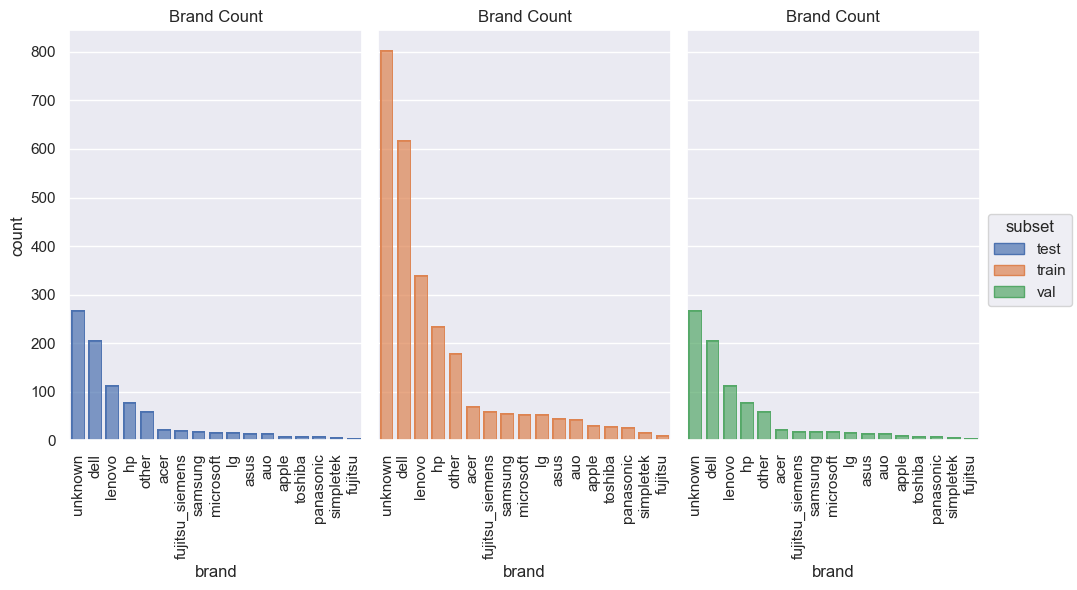

In [38]:
fig = plt.figure(figsize=(10, 6))

(
    so.Plot(proportion_data, x="brand", y='count', color='set')
    .add(so.Bar())
    .on(fig)
    .facet('set')
    .label(title='Brand Count', color='subset')
    .plot()
)

for ax in fig.axes:
    ax.tick_params(axis='x', rotation=90)

fig.tight_layout()


We can also take a look at the brand proportion in each subset:

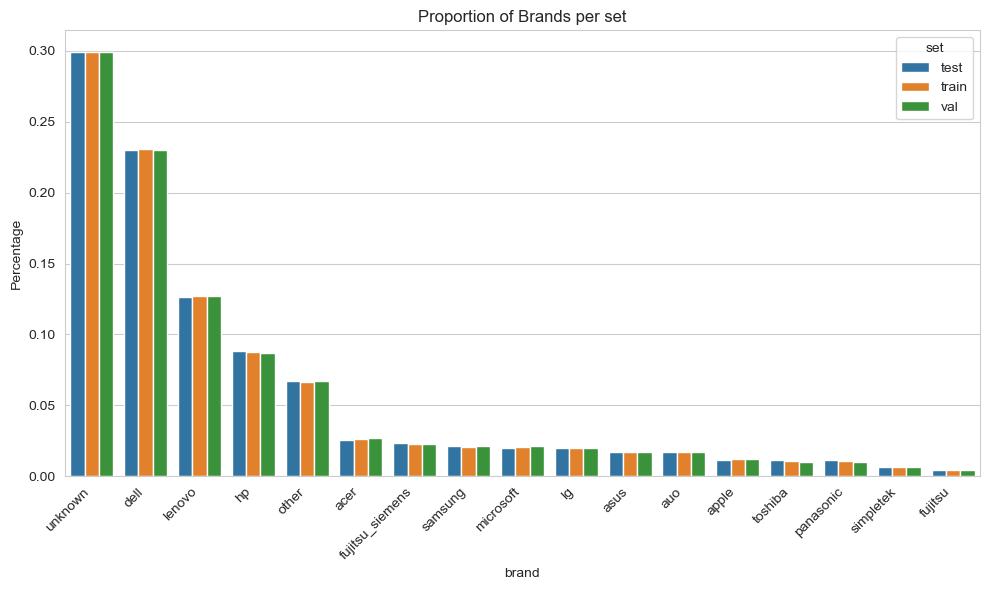

In [39]:
# Plot the normalized data (percentages)
plt.figure(figsize=(10, 6))
sns.barplot(data=proportion_data, x='brand', y='proportion', hue='set')

# Add labels and title
plt.title('Proportion of Brands per set')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Percentage')
plt.tight_layout()
plt.show()

In summary, by doing stratified sampling, we have ensured that the distribution of brands remains consistent across train, validation, and test sets, preserving the statistical properties of the original dataset.

This is crucial as without stratification, rare brands might be underrepresented in certain subsets, leading to biased model training, overfitting and poor generalization.

Now we convert the data from Polars `DataFrames` and `Series` into NumPy `ndarray`, in order to make it compatible with machine learning libraries like `scikit-learn` or `catboost`.

In [40]:
X_train = df_train.to_numpy()
y_train = series_train.to_numpy()
X_val = df_val.to_numpy()
y_val = series_val.to_numpy()
X_test = df_test.to_numpy()
y_test = series_test.to_numpy()

### Categorical Boosting

**CatBoost** is a gradient boosting algorithm that builds decision trees sequentially, improving predictions at each step (*Ensemble learning*).

A key feature is how CatBoost handles **categorical** data (hence its name). Instead of one-hot encoding or label encoding, it uses **target encoding**, where categories are replaced by smoothed target statistics, essentially *converting categorical values into numerical values*.

Additionally, trees CatBoost builds are **oblivious trees**, meaning that every split at a given depth applies the same condition across all nodes. This structure helps prevent overfitting, improves generalization, and makes computation highly efficient, especially on GPUs.

Overall, CatBoost refines the traditional gradient boosting approach by handling categorical data naturally, and optimizing computation, making it one of the best choices for tabular data problems with a considerable amount of categorical variables.

<div align="center">
<img src="../assets/images/categorical_boosting.png" height="375" width="375"/>
<br>
<a href="https://www.researchgate.net/figure/The-flow-diagram-of-the-CatBoost-model_fig3_370695897"><i>The flow diagram of the CatBoost model</i></a>
</div>

In [41]:
train_pool = cb.Pool(data=X_train, label=y_train, cat_features=cat_feature_names, feature_names=feature_names)
val_pool = cb.Pool(data=X_val, label=y_val, cat_features=cat_feature_names, feature_names=feature_names)

In [42]:
catboost = cb.CatBoostRegressor(loss_function='RMSE')
catboost.fit(X=train_pool, eval_set=val_pool, logging_level='Silent')

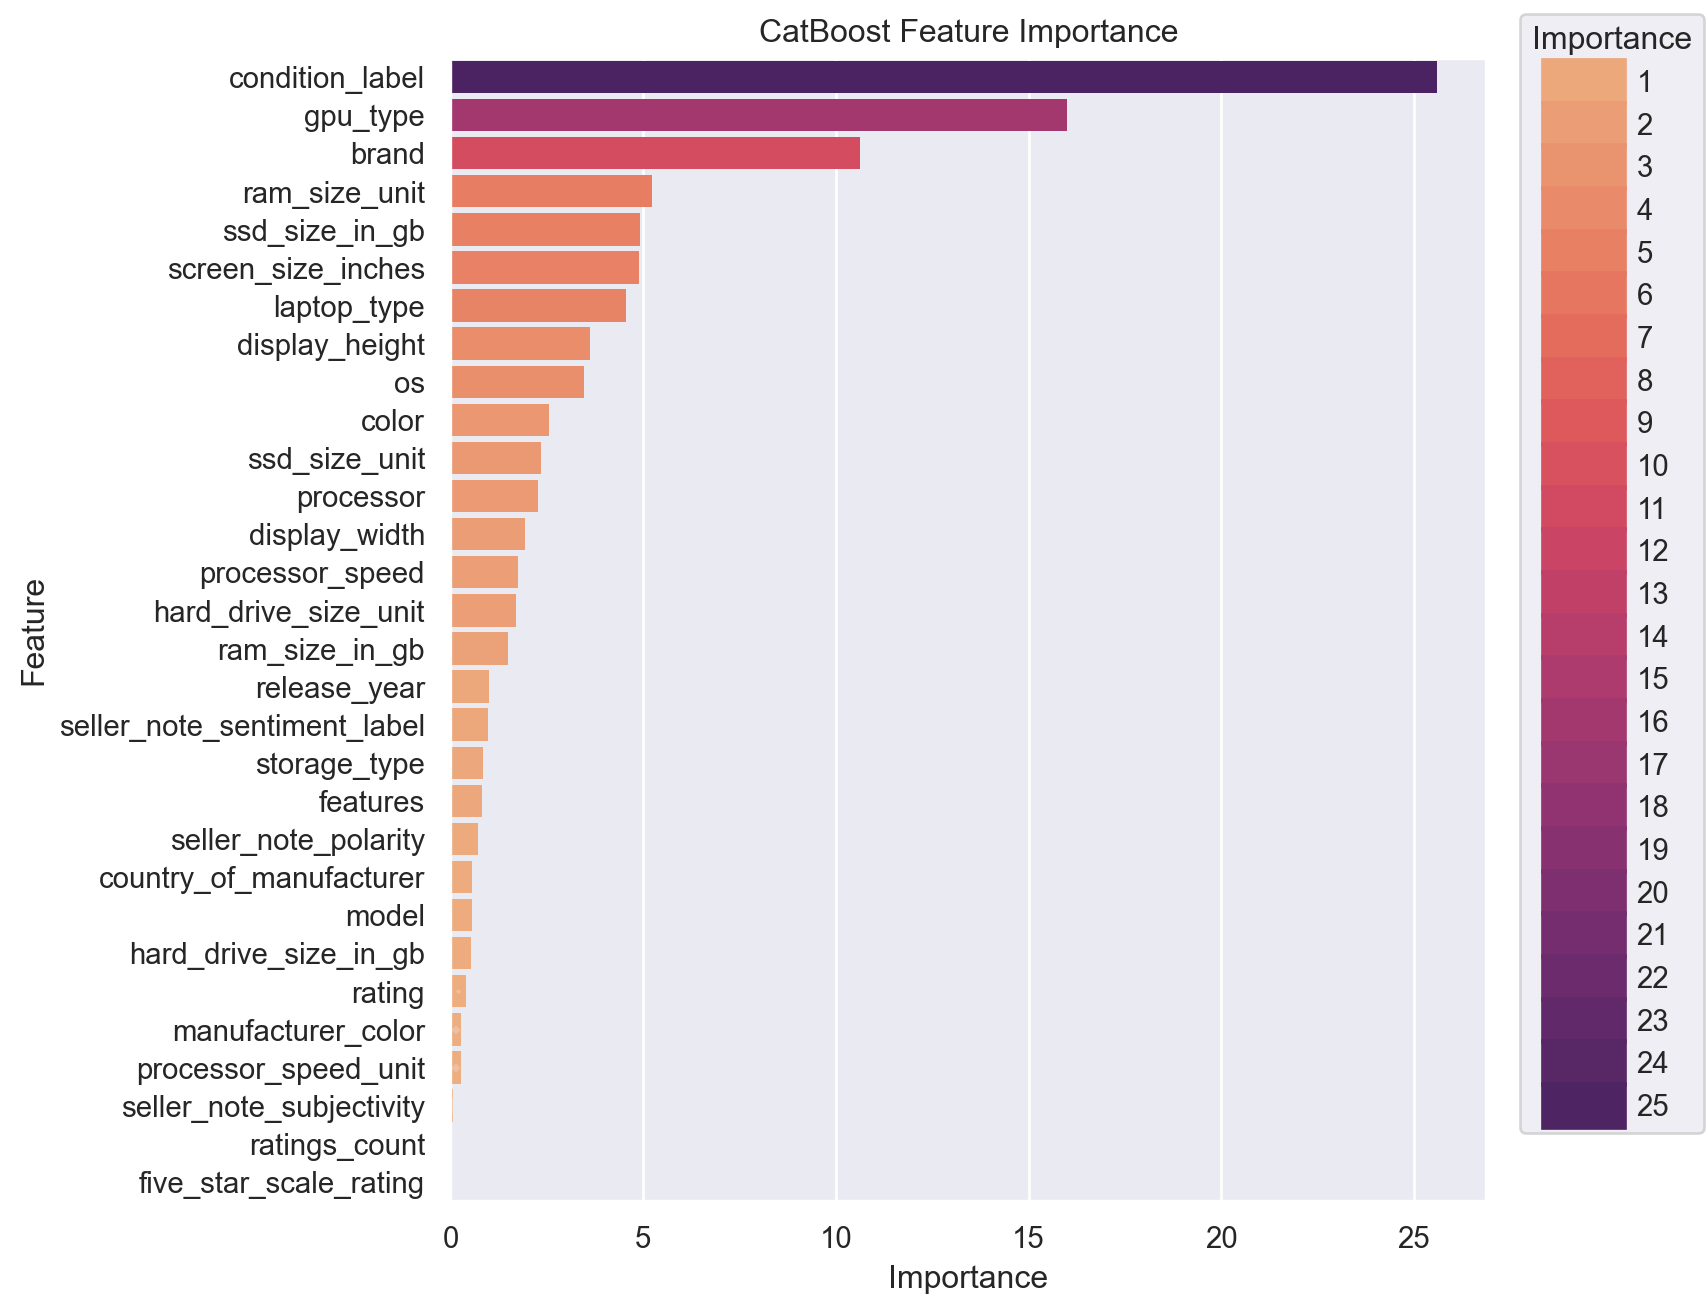

In [43]:

catboost_feature_importance = pl.DataFrame({
    'feature': catboost.feature_names_,
    'importance': catboost.feature_importances_,
}).sort(by='importance', descending=True)

(
    so.Plot(catboost_feature_importance, x='importance', y='feature', color='importance')
    .add(
        so.Bar(edgewidth=10, width=0.85)
    ).label(
        title='CatBoost Feature Importance', x='Importance', y='Feature', color='Importance'
    ).scale(
        color=so.Continuous('flare').tick(every=1),
    )
    .theme(
        style.library['fast']
    ).layout(size=(8, 7))
)

In [44]:
# Make predictions using the trained model on both the training and validation data
y_train_pred = catboost.predict(train_pool)
y_val_pred = catboost.predict(val_pool)

# Calculate the Root Mean Squared Error (RMSE) scores for training and validation data
rmse_train = root_mean_squared_error(series_train, y_train_pred)
rmse_val = root_mean_squared_error(series_val, y_val_pred)

# Calculate the Mean Absolute Error (MAE) scores for training and validation data
mae_train = mean_absolute_error(series_train, y_train_pred)
mae_val = mean_absolute_error(series_val, y_val_pred)

# Print the rounded RMSE scores
print(f"RMSE score for train {round(rmse_train)} USD & for validation {round(rmse_val)} USD")
print(f"MAE score for train {round(mae_train)} USD & for validation {round(mae_val)} USD")

RMSE score for train 244 USD & for validation 227 USD
MAE score for train 123 USD & for validation 121 USD


## Hyperparameter Tuning

Hyperparameter tuning is the process of selecting the most optimal set of hyperparameters for a machine learning model to improve its performance. These hyperparameters are set before training and control aspects like learning rate, model complexity, and regularization. The goal is to find the combination that leads to the best results in terms of accuracy, speed, or other performance metrics.

### Why It Matters:
- **Hyperparameters**: Unlike model parameters that are learned from the data, hyperparameters are fixed before training. Examples include the learning rate, number of hidden layers in a neural network, or the number of trees in a random forest.
- **Objective**: The goal is to adjust these hyperparameters to minimize the error or loss function, ultimately making the model generalize well to unseen data.

### Common Approaches:
- **Grid Search**: Tests all combinations of hyperparameters in a predefined grid, but it’s computationally expensive.
- **Random Search**: Randomly selects hyperparameter values from a specified range, offering a more efficient exploration compared to grid search.
- **Bayesian Optimization**: Uses models to predict the performance of different hyperparameter combinations and explores the space in a smarter way, often using fewer trials to find the best values.

For this project, we will use **Optuna**, a state-of-the-art library which employs *Bayesian Optimization*, a more efficient approach that intelligently explores the hyperparameter space, balancing exploration and exploitation to quickly find the best-performing parameters with fewer trials.

<br>
<div align="center">
<img src="../assets/logos/optuna.png" height="200" width=400"/>
</div>

### Objective Function

In [ ]:
def objective(trial):
    # Define hyperparameter search space for optimization
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),  # Number of iterations
        'depth': trial.suggest_int('depth', 3, 6),  # Max depth of trees
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),  # Learning rate
        'loss_function': 'RMSE',  # Loss function to optimize
        'verbose': 0,  # Set verbosity level to 0
        'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 20, 100),  # Early stopping
    }

    # Train CatBoostRegressor with suggested parameters
    model = cb.CatBoostRegressor(**params, thread_count=N_CORES_HALF)
    model.fit(train_pool, eval_set=val_pool)

    # Make predictions and calculate RMSE on the validation set
    pred = model.predict(val_pool)
    trial_rmse = root_mean_squared_error(series_val, pred)

    return trial_rmse


### Bayesian Optimization

#### Tree Structured Parzen Estimator (TPE)

A **Tree-structured Parzen Estimator** is a probabilistic model that models the distribution of hyperparameters in a hierarchical (tree-structured) way. The key idea is to use a non-parametric density estimator, based on the Parzen Estimator, to represent the probability distribution of the hyperparameters.

By introducing a threshold ($y^*$), TPE divides the observed data into two subsets:

\begin{split}
l(x) = & \, \text{PDF for hyperparameters with performance } y < y^*, \\
g(x) = & \, \text{PDF for hyperparameters with performance } y \geq y^*.
\end{split}

These subsets are then used to construct non-parametric density estimators, typically Gaussian Mixture Models (GMMs), which approximate the distributions of hyperparameters associated with different performance levels.

During the optimization process, TPE seeks hyperparameter configurations that maximize the ratio:

\begin{split}
\frac{l(x)}{g(x)}
\end{split}

This focuses the search on regions of the hyperparameter space that are more likely to yield superior performance.


<div align="center">
<img src="../assets/images/random_search_vs_smbo.png" height="300" width=700"/>
</div>

#### Pruning

Pruning trials is a strategy that stops unproductive attempts early, freeing up resources to focus on more promising ones. The pruner evaluates the performance of ongoing trials and terminates those that are unlikely to lead to the best results, thus saving computational resources.

We'll use Optuna's `HyperbandPruner`, acknowledged by official Optuna benchmarks to be [the best pruner when paired with the `TPESampler`][Pruning] (for non-deep-learning predictive modeling).

<div align="center">
<img src="../assets/images/pruning_trials.png" height="225" width=500"/>
</div>

[Pruning]: https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/003_efficient_optimization_algorithms.html#which-sampler-and-pruner-should-be-used


Ultimately, we define the `TPESampler` and `HyperbandPruner` and proceed to run the study to minimize the objective function. The number of trials is fixed and defined below:

In [ ]:
# Number of trials, it is advised to set at least 100 trials.
N_TRIALS = 100

tpe_sampler = optuna.samplers.TPESampler(seed=RANDOM_SEED)
hyperband_pruner = optuna.pruners.HyperbandPruner()

study = optuna.create_study(study_name='catboost-hopt', sampler=tpe_sampler, pruner=hyperband_pruner,
                            direction='minimize')
study.optimize(objective, n_trials=N_TRIALS, n_jobs=N_CORES_HALF)

In [ ]:
print(f'Best Trial: #{study.best_trial.number}')
print(f'Best Trial Value: {study.best_trial.value}')
print(f'Best Trial Params: {study.best_trial.params}')

In [ ]:
vis.plot_param_importances(study)

In [ ]:
fig = vis.plot_parallel_coordinate(study)
fig.update_layout(
    title="Hyperparameter Tuning for CatBoost - Parallel Coordinate Plot",
    title_font=dict(family="Arial", size=18, color="black", weight="bold"),  # Bold title
    title_x=0.5,
    font=dict(family="Arial", size=14, color="black")
)

# Access the traces to modify the line colorscale
fig.data[0].line.colorscale = plotly.colors.sequential.Reds
fig

## Explainable AI - SHAP

### Understanding Model Decisions

- **SHAP (SHapley Additive exPlanations)** is a method used to explain machine learning models by showing how much each input factor (feature) contributes to a prediction.
- It helps us see which features are **driving the model’s decisions**—whether they increase or decrease the predicted outcome.
- The **summary plot** provides a visual representation of feature importance, showing:
  - Which features **have the most impact** overall.
  - Whether a feature **positively or negatively influences** predictions.
  - How the values of these features interact with the model.

<div align="center">
<img src="../assets/logos/shap.png" height="200" width="200"/>
</div>

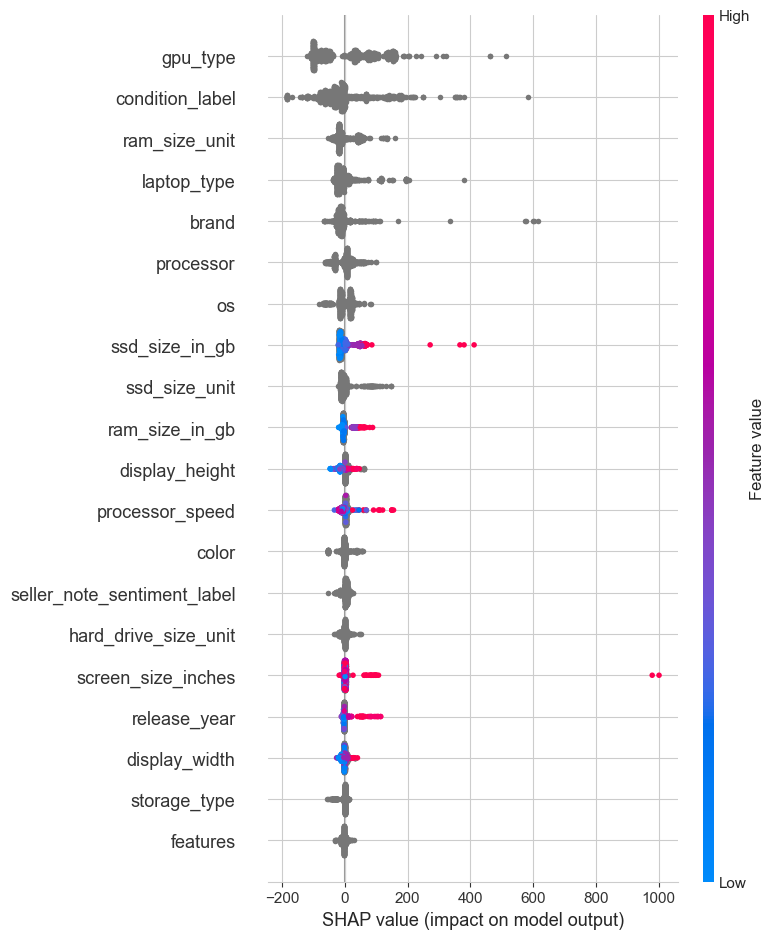

In [45]:
# Run SHAP
shap.initjs()
tree_explainer = shap.TreeExplainer(catboost)
shap_values = tree_explainer.shap_values(X_val)

# Pass feature names manually
shap.summary_plot(shap_values, X_val, feature_names=feature_names)